In [261]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Data was explored and the result was saved in the csv file and this section the clean data is used.

In [262]:
df=pd.read_csv("output.csv")


In [263]:
df

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0,1,0,1,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,1,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,1,R,75,12,4.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,1,R,76,12,4.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,1,R,80,12,4.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1,2,842,1,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1,3,2297,1,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0,1,0,0,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0,2,763,0,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [264]:
df.Visit.value_counts()

Visit
1    150
2    150
3     56
4     13
5      4
Name: count, dtype: int64

Cut only firsts and seconds and third visits

In [265]:
df_copy = df.copy()
has_third_subject_id = df[df["Visit"] == 3]["Subject ID"].values
df = df[df['Subject ID'].isin(has_third_subject_id)]
df = df[df["Visit"] < 4]
df.reset_index(drop = True, inplace = True)
df = pd.get_dummies(df, columns = ["Visit"],prefix = "Visit")

In [266]:
visit_3 = df[df["Visit_3"] == 1][["Subject ID","Group"]]
df = df.drop(visit_3.index, axis = 0).reset_index(drop = True).drop("Visit_3", axis = 1)

Split Data


In [267]:
RANDOM_STATE = 13
splitter = GroupShuffleSplit(test_size=.20, n_splits=1,
random_state = RANDOM_STATE)
split = splitter.split(df, groups=df['Subject ID'])
train_indexes, test_indexes = next(split)
X_train = df.iloc[train_indexes]
X_test = df.iloc[test_indexes]


Normalization


In [268]:
delay_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()
educ_scaler = MinMaxScaler()
mmse_scaler = MinMaxScaler()
etiv_scaler = MinMaxScaler()
delay_scaler.fit(X_train["MR Delay"].to_numpy().reshape(-1,1))
age_scaler.fit(X_train["Age"].to_numpy().reshape(-1,1))
educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1,1))
mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1,1))
etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1,1))
X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1,1))
X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1,1))
X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1,1))
X_test["MR Delay"] = delay_scaler.transform(X_test["MR Delay"].to_numpy().reshape(-1,1))
X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1,1))
X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1,1))
X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1,1))
X_test["eTIV"] = etiv_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_4404\2500005561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_4404\2500005561.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_4404\2500005561.py:13: SettingWithCopyWarning: 
A value is trying to be set on a 

In [269]:
X_train

,Subject ID,MRI ID,Group,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2
2,OAS2_0005,OAS2_0005_MR1,0,0.000000,1,R,0.588235,0.352941,4.0,0.866667,0.0,0.764977,0.712,1.039,True,False
3,OAS2_0005,OAS2_0005_MR2,0,0.649936,1,R,0.676471,0.352941,4.0,0.933333,0.5,0.783410,0.711,1.032,False,True
4,OAS2_0007,OAS2_0007_MR1,1,0.000000,1,R,0.323529,0.588235,2.0,0.866667,0.5,0.254992,0.748,1.293,True,False
5,OAS2_0007,OAS2_0007_MR3,1,0.333333,1,R,0.382353,0.588235,2.0,0.800000,1.0,0.267281,0.727,1.286,False,True
6,OAS2_0012,OAS2_0012_MR1,0,0.000000,0,R,0.529412,0.588235,2.0,0.933333,0.0,0.218126,0.748,1.316,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,OAS2_0183,OAS2_0183_MR2,0,0.117117,0,R,0.176471,0.411765,2.0,1.000000,0.0,0.483871,0.740,1.165,False,True
108,OAS2_0185,OAS2_0185_MR1,1,0.000000,1,R,0.588235,0.588235,1.0,0.866667,0.5,0.788018,0.711,1.030,True,False
109,OAS2_0185,OAS2_0185_MR2,1,0.541828,1,R,0.647059,0.588235,1.0,0.866667,0.5,0.771121,0.694,1.037,False,True
110,OAS2_0186,OAS2_0186_MR1,0,0.000000,0,R,0.029412,0.411765,2.0,1.000000,0.0,0.196621,0.801,1.331,True,False


Train Test Final

In [270]:
y_train_final = []
for id in X_train["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_train_final.append(res)
y_test_final = []
for id in X_test["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_test_final.append(res)
y_train_super_final = pd.DataFrame({
"Group": y_train_final})
y_test_super_final = pd.DataFrame({
"Group": y_test_final})


In [271]:
X_test = X_test.drop(["Subject ID","MRI ID","Hand"], axis = 1)
X_train = X_train.drop(["Subject ID","MRI ID","Hand"], axis = 1)

In [272]:
X_train = np.random.random((88, 13))  
X_train_super_final = np.reshape(X_train, (44, 26))
X_test = np.random.random((24, 13))
X_test_super_final = np.reshape(X_test, (12, 26))



Model

In [273]:
# Deploy SVM Classifier
LinearSVsvm_classifier = SVC(kernel='poly', C=1.0)
classifier=LinearSVsvm_classifier.fit(X_train_super_final, y_train_super_final)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[3 3]
 [4 2]]


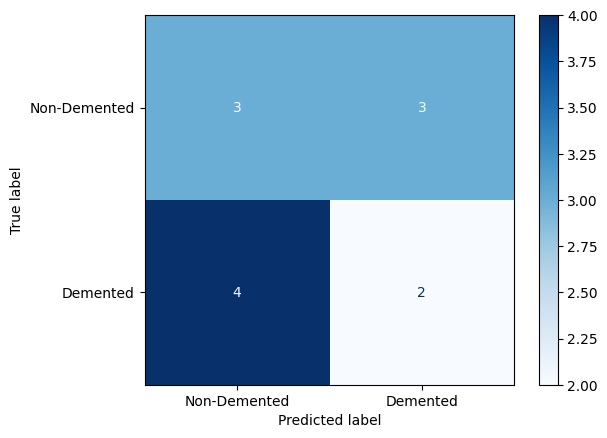

In [274]:
# Calculate the confusion matrix
y_pred = classifier.predict(X_test_super_final)
conf_matrix = confusion_matrix(y_test_super_final, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Plot the confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Demented", "Demented"])
confusion_matrix_display.plot(cmap='Blues', values_format='d')
plt.show()  # Display the confusion matrix plot




In [275]:
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]
TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
accuracy1=(TP+TN)/(TP+FP+FN+TN)
recall1=TP/(TP+FN)
percision1=TP/(TP+TN)
print(round(accuracy1,2),round(recall1,2),round(percision1,2))

0.42 0.33 0.4
